In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import gc

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import MinMaxScaler
import os

import scipy as sp

# _FOLDER = "/home/acq18mk/master/results/results/"
_FOLDER = "results/"

### Coding Part

with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    
# #columns to normalise:
# with open(_FOLDER+"columns_to_normalise.txt", 'r') as f:
#     columns_to_normalise = [line.rstrip('\n') for line in f]
# # *****************************************

with open(_FOLDER+"X_features_cancer_cell_lines.txt", 'r') as f:
    X_cancer_cell_lines = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_PubChem_properties.txt", 'r') as f:
    X_PubChem_properties = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Targets.txt", 'r') as f:
    X_targets = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Target_Pathway.txt", 'r') as f:
    X_target_pathway = [line.rstrip('\n') for line in f]
# *****************************************

In [2]:
GDSC_Info = pd.read_csv(_FOLDER+"Cell_list_GDSC.csv")  #Contains info of cancer types for both GDSC1 and GDSC2

In [3]:
df_GDSC1 = GDSC_Info[GDSC_Info["Dataset"]=="GDSC1"] 

In [4]:
df_OneCancer = df_GDSC1[df_GDSC1["Tissue"]=="lung"].reset_index()

In [5]:
df_OneCancer["COSMICID"][0]

687596

In [6]:
all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway +["MAX_CONC"]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

datasets = ["Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4"]

X_feat_dict = {"Dataset 1": X_cancer_cell_lines ,
               "Dataset 2": ["MAX_CONC"] + X_targets + X_target_pathway + X_cancer_cell_lines ,
               "Dataset 3": ["MAX_CONC"] + X_PubChem_properties +  X_cancer_cell_lines,
               "Dataset 4": ["MAX_CONC"] + X_PubChem_properties +  X_targets + X_target_pathway + X_cancer_cell_lines}

### Coefficient_1

train_drug = train_df_50.copy()
test_drug = test_df_50.copy()
  
data_set = "Dataset 4" 
X_columns = X_feat_dict[data_set]

In [7]:
df_train_drug_new = train_drug[train_drug["COSMIC_ID"]==df_OneCancer["COSMICID"][0]]
for i in range(1,df_OneCancer.shape[0]):
    df_aux = train_drug[train_drug["COSMIC_ID"]==df_OneCancer["COSMICID"][i]]
    df_train_drug_new = pd.concat([df_train_drug_new, df_aux])
    
df_test_drug_new = test_drug[test_drug["COSMIC_ID"]==df_OneCancer["COSMICID"][0]]
for i in range(1,df_OneCancer.shape[0]):
    df_aux = test_drug[test_drug["COSMIC_ID"]==df_OneCancer["COSMICID"][i]]
    df_test_drug_new = pd.concat([df_test_drug_new, df_aux])

In [8]:
df_train_drug_new = df_train_drug_new.reset_index()
df_test_drug_new = df_test_drug_new.reset_index()

In [9]:
scaler = MinMaxScaler().fit(df_train_drug_new[X_columns])
Xtrain_drug = scaler.transform(df_train_drug_new[X_columns])
Xtest_drug = scaler.transform(df_test_drug_new[X_columns])

y_train_drug = np.clip(df_train_drug_new["norm_cells_"+str(1)].values[:,None],1.0e-9,np.inf)
y_test_drug =  np.clip(df_test_drug_new["norm_cells_"+str(1)].values[:,None],1.0e-9,np.inf)
print(y_train_drug.shape)
for i in range(2,10):
    y_train_drug = np.concatenate((y_train_drug,np.clip(df_train_drug_new["norm_cells_"+str(i)].values[:,None],1.0e-9,np.inf)),1)
    y_test_drug = np.concatenate((y_test_drug,np.clip(df_test_drug_new["norm_cells_"+str(i)].values[:,None],1.0e-9,np.inf)),1)    

(3417, 1)


In [10]:
### Training data for the GP ###
output_dim = y_train_drug.shape[1]
N_per_out = Xtrain_drug.shape[0]
#aux_label_outputs = np.tile(np.arange(0,output_dim),(N_per_out,1)).T.reshape(-1) #Create labels for X
Xall = Xtrain_drug.copy()  #Here replicate (10,1) due to having ten outputs.
#Xtrain = np.concatenate((Xtrain,aux_label_outputs[:,None]),axis=1)
Yall = y_train_drug.copy()

### Testing data for the GP ###
N_per_out_test = Xtest_drug.shape[0]
#aux_label_outputs_test = np.tile(np.arange(0,output_dim),(N_per_out_test,1)).T.reshape(-1) #Create labels for X
Xtest = Xtest_drug.copy()  #Here replicate (10,1) due to having ten outputs.
#Xtest= np.concatenate((Xtest,aux_label_outputs_test[:,None]),axis=1)
Ytest = y_test_drug.copy()

In [22]:
np.random.seed(1001)
ind_perm = np.random.permutation(np.arange(0, Yall.shape[0]))
perc_train = 0.75
Ntrain = int(Yall.shape[0]*perc_train)
#Nval = Ytrain.shape[0] - Ntrain 
Xval = Xall[ind_perm[Ntrain:],:].copy()
Xtrain = Xall[ind_perm[0:Ntrain],:].copy()
Yval = Yall[ind_perm[Ntrain:],:].copy()
Ytrain = Yall[ind_perm[0:Ntrain],:].copy()
print("Training N:", Ytrain.shape)
print("Validation N:", Yval.shape)

Training N: (2562, 9)
Validation N: (855, 9)


In [12]:
import math
import torch
import gpytorch
import tqdm
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [13]:
_,myDim = Xtrain.shape
#train_x = 1/myDim*torch.randn((10000,myDim))

In [14]:
#train_x.sum(1)
#train_x.size(0)
train_x = torch.from_numpy(Xtrain.astype(np.float32))
train_y = torch.from_numpy(Ytrain.astype(np.float32))
val_x = torch.from_numpy(Xval.astype(np.float32))
val_y = torch.from_numpy(Yval.astype(np.float32))
#test_x = torch.from_numpy(Xtest.astype(np.float32))
#test_y = torch.from_numpy(Ytest.astype(np.float32))

In [15]:
print(train_x.shape, train_y.shape)

from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

#test_dataset = TensorDataset(test_x, test_y)
#test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

torch.Size([2562, 1352]) torch.Size([2562, 9])


In [16]:
num_latents = 9
num_tasks = Ytrain.shape[1]
split_dim = 2

class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.rand(num_latents, 200, myDim)

        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        
        Dim = Xtrain.shape[1]
        "here is Dim and Not Dim-1, I alredy substracted the -1 before"
        size_dims = (Dim)//split_dim

        #mykern = gpytorch.kernels.RBFKernel(active_dims=torch.tensor(list(np.arange(0,size_dims))),batch_shape=torch.Size([num_latents]))
        mykern = gpytorch.kernels.RBFKernel(active_dims=torch.tensor(list(np.arange(0,size_dims))),batch_shape=torch.Size([num_latents]))
        for i in range(1,split_dim):
            if i != (split_dim-1):
                mykern = mykern + gpytorch.kernels.RBFKernel(active_dims=torch.tensor(list(np.arange(size_dims*i,size_dims*i+size_dims))),batch_shape=torch.Size([num_latents]))
                #print(torch.tensor(list(np.arange(size_dims*i,size_dims*i+size_dims))))
            else:
                mykern = mykern + gpytorch.kernels.RBFKernel(active_dims=torch.tensor(list(np.arange(size_dims*i,Dim))),batch_shape=torch.Size([num_latents]))
                #print(torch.tensor(list(np.arange(size_dims*i,Dim))))

        
        self.covar_module = gpytorch.kernels.ScaleKernel(mykern,
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model = MultitaskGPModel()
for i in range(split_dim):
    model.covar_module.base_kernel.kernels[i].lengthscale = torch.tensor([[[np.sqrt(myDim)*0.006*np.random.rand()]],[[np.sqrt(myDim)*0.3*np.random.rand()]],[[np.sqrt(myDim)*0.02*np.random.rand()]],[[np.sqrt(myDim)*0.001*np.random.rand()]],[[np.sqrt(myDim)*0.01*np.random.rand()]],[[np.sqrt(myDim)*0.1*np.random.rand()]],[[np.sqrt(myDim)*0.5*np.random.rand()]],[[np.sqrt(myDim)*1.0*np.random.rand()]],[[np.sqrt(myDim)*3*np.random.rand()]]])
#model.covar_module.base_kernel.lengthscale=torch.tensor([[[np.sqrt(myDim)*5]],[[np.sqrt(myDim)*0.0003]],[[np.sqrt(myDim)*0.006]],[[np.sqrt(myDim)*0.3]],[[np.sqrt(myDim)*0.02]],[[np.sqrt(myDim)*0.001]],[[np.sqrt(myDim)*0.01]],[[np.sqrt(myDim)*0.1]],[[np.sqrt(myDim)*0.5]],[[np.sqrt(myDim)*1.0]],[[np.sqrt(myDim)*3]]])
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks,noise_constraint=gpytorch.constraints.Interval(1.0e-5, 1.0e-3))

In [17]:
#likelihood(model(train_x)).rsample().shape

In [18]:
state_dict = torch.load('model_RBF.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [439]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_epochs = 1 if smoke_test else 1


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.0005)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
# epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
# for i in epochs_iter:
#     # Within each iteration, we will go over each minibatch of data
#     optimizer.zero_grad()
#     output = model(train_x)
#     loss = -mll(output, train_y)
#     epochs_iter.set_postfix(loss=loss.item())
#     loss.backward()
#     optimizer.step()

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/26 [00:00<?, ?it/s]

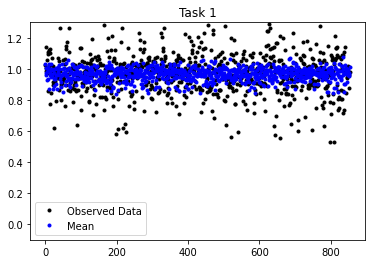

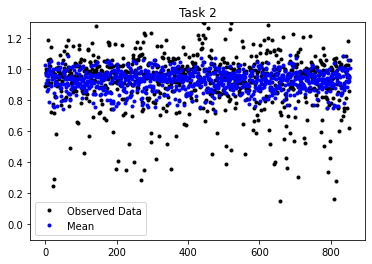

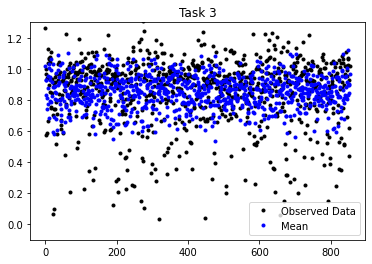

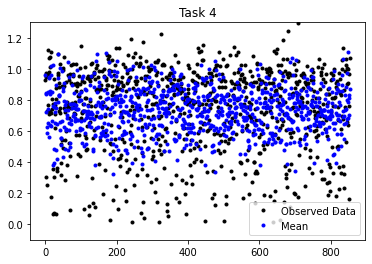

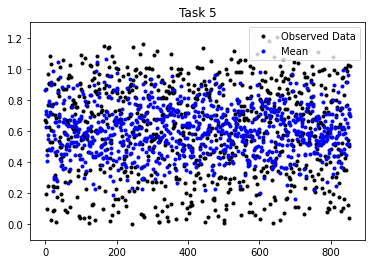

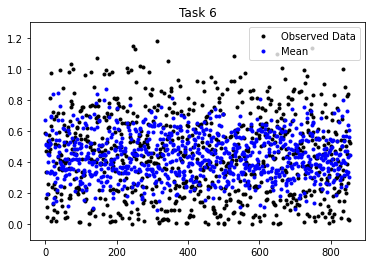

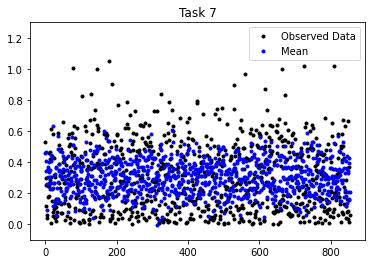

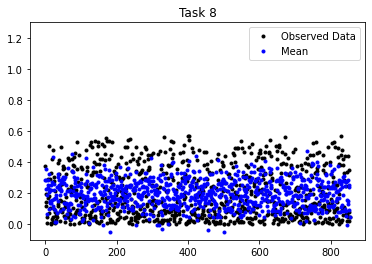

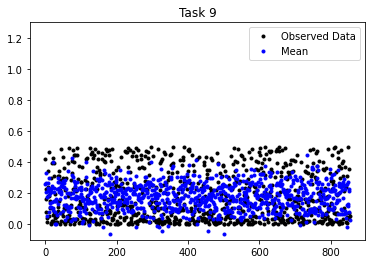

In [19]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
#fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(val_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

for task in range(num_tasks):
    # Plot training data as black stars
    plt.figure(task)
    plt.plot(val_y[:, task].detach().numpy(), 'k.')
    # Predictive mean as blue line
    plt.plot(mean[:, task].numpy(), '.b')
    # Shade in confidence
    #ax.fill_between(test_x.numpy(), lower[:, task].numpy(), upper[:, task].numpy(), alpha=0.5)
    plt.ylim([-0.1, 1.3])
    plt.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.title(f'Task {task + 1}')

#fig.tight_layout()
None

In [20]:
r2_scr = r2_score(val_y.T, mean.T, multioutput='raw_values')[:,None]
print("Median: ",np.median(r2_scr))
print("Mean: ",np.mean(r2_scr))
#r2_scr.shape

Median:  0.7831052885960643
Mean:  0.49348960071492987


(array([  9.,   4.,   5.,  11.,   8.,  11.,  17.,  11.,  23.,  25.,  21.,
         26.,  44.,  42.,  48.,  68., 101., 120., 135.,  44.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

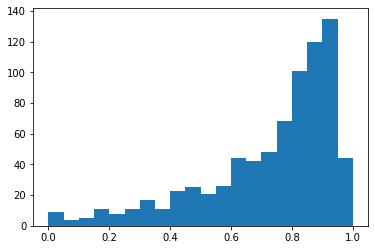

In [21]:
#(r2_scr>0.8).sum()
#r2_scr.shape
plt.hist(r2_scr,range=[0,1.0],bins=20)

In [296]:
print(model.covar_module.base_kernel.kernels[5].lengthscale)

tensor([[[5.5255e-02]],

        [[6.4887e+00]],

        [[7.2477e-01]],

        [[1.9101e-02]],

        [[2.2536e-01]],

        [[4.4355e-01]],

        [[1.6833e+01]],

        [[2.3994e+01]],

        [[6.0708e+01]]], grad_fn=<SoftplusBackward0>)


In [67]:
model.covar_module.base_kernel.lengthscale=torch.tensor([[[0.1]],[[0.6]],[[0.2]],[[0.7]]])

In [183]:
model.covar_module.base_kernel.lengthscale

In [164]:
k

RBFKernel(
  (raw_lengthscale_constraint): Positive()
)

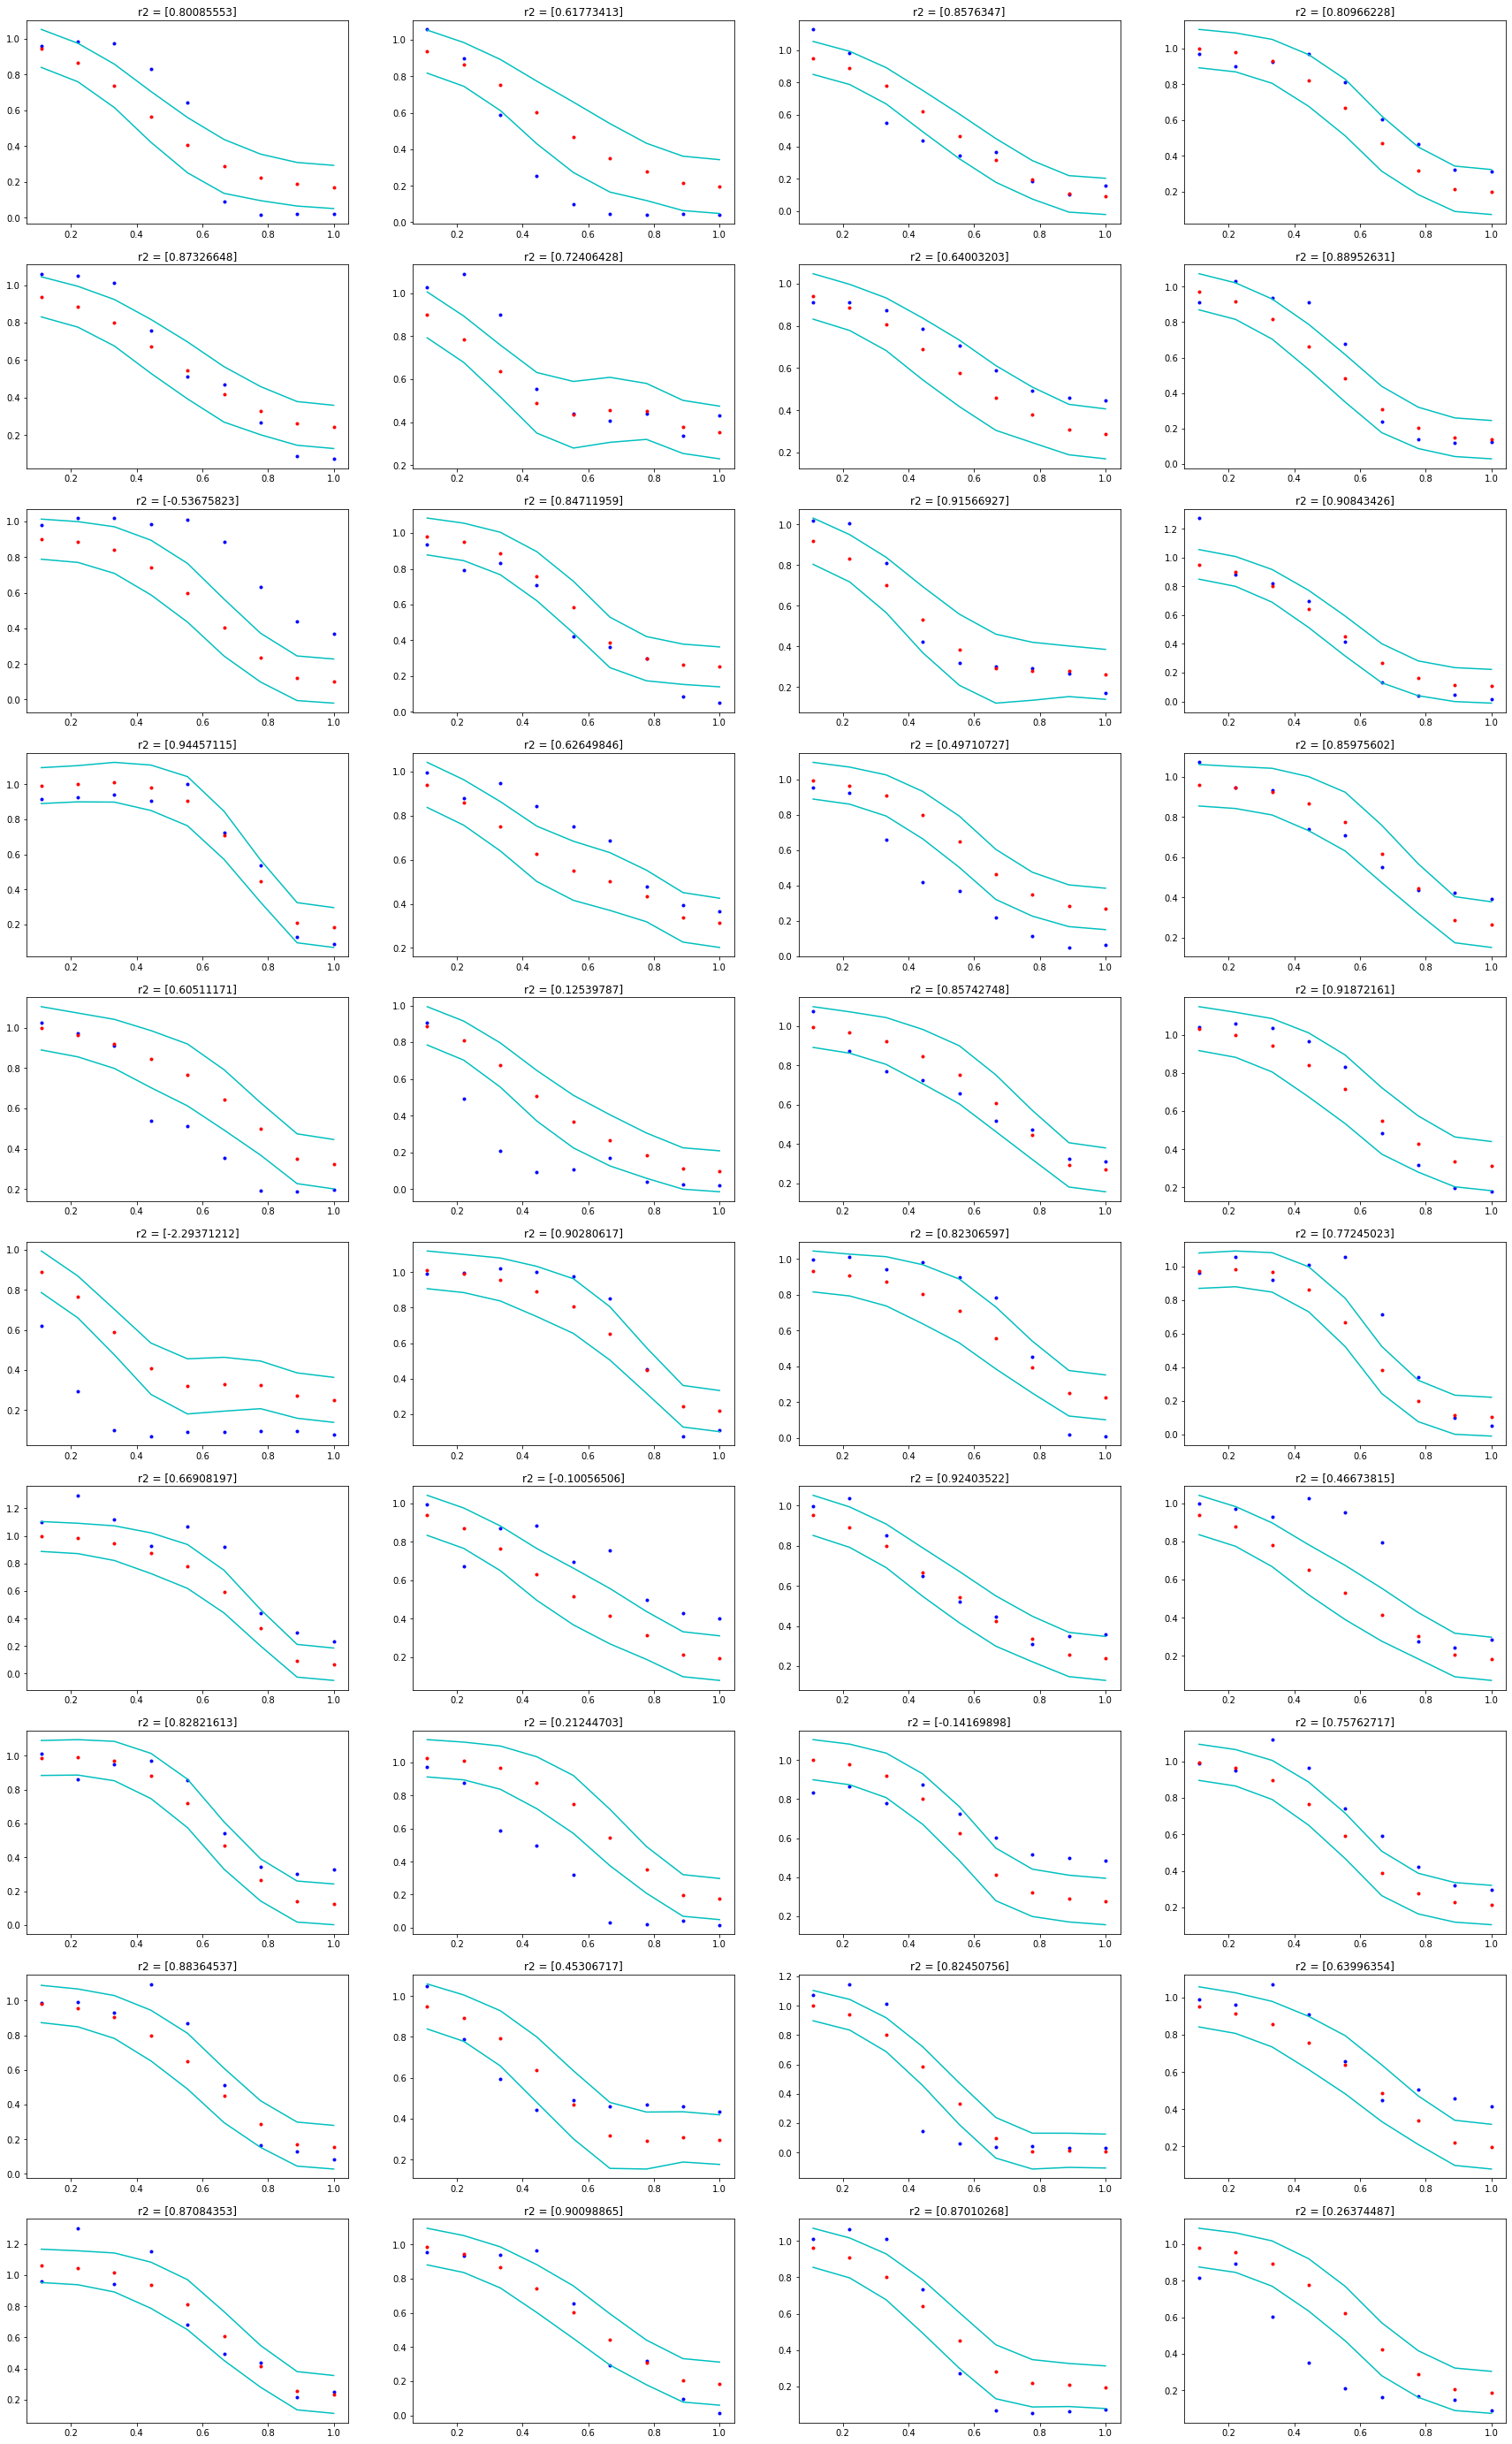

In [438]:
Nrow = 10
Ncolumn = 4
fig, axs = plt.subplots(Nrow, Ncolumn, figsize=(30,50))

#test_y, mean
for i in range(Nrow):
    for j in range(Ncolumn): 
        posy = np.random.randint(val_y.shape[0])
        axs[i, j].plot(np.linspace(0.11,1,9), val_y[posy,:],'.b')
        axs[i, j].plot(np.linspace(0.11,1,9), mean[posy,:],'.r')
        axs[i, j].plot(np.linspace(0.11,1,9), lower[posy,:],'-c')
        axs[i, j].plot(np.linspace(0.11,1,9), upper[posy,:],'-c')
        axs[i, j].set_title("r2 = "+str(r2_scr[posy,:]))

In [92]:
likelihood.raw_task_noises#=torch.tensor([-1,-1,-1,-1,-1,-1,-1,-1,-1])

Parameter containing:
tensor([2.3449, 3.4594, 4.0393, 3.8626, 3.8383, 4.2147, 3.9125, 3.3786, 3.1791],
       requires_grad=True)

In [63]:
likelihood.raw_task_noises_constraint

TypeError: cannot assign 'torch.LongTensor' as parameter 'raw_task_noises' (torch.nn.Parameter or None expected)

In [443]:
torch.save(model.state_dict(), 'model_RBF.pth')